In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import Data2Graph
import pickle as pk

from stgcn import STGCN
from utils import generate_dataset, get_normalized_adj

Using backend: pytorch


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
data_filename='us-counties.csv'
auxiliary_filename='uszips.csv'

feat_tensor, Adj, active_cases, confirmed_cases, popn, selected_counties,g = Data2Graph.load_data(data_filename, auxiliary_filename, active_thresh=1000)
cases = torch.stack([active_cases,confirmed_cases],dim=2)
np.save('Adj',Adj.numpy())
np.save('cases',cases.numpy())

Feature tensor is of size  torch.Size([52, 180, 6])


In [12]:


A = np.load("Adj.npy")
X = np.load("cases.npy").transpose((0, 2, 1))
def training(num_timesteps_input,num_timesteps_output,A,X,epochs = 100):
    '''return the MAPE value of given timesteps and save the ground truth vs predict figure'''
    def train_epoch(training_input, training_target, batch_size):

        permutation = torch.randperm(training_input.shape[0])

        epoch_training_losses = []
        for i in range(0, training_input.shape[0], batch_size):
            net.train()
            optimizer.zero_grad()

            indices = permutation[i:i + batch_size]
            X_batch, y_batch = training_input[indices], training_target[indices]

            out = net(A_wave, X_batch)
            loss = loss_criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            epoch_training_losses.append(loss.detach().cpu().numpy())
        return sum(epoch_training_losses) / len(epoch_training_losses)

    batch_size = 20
    lr = 1e-4
    torch.manual_seed(1)
    X = X.astype(np.float32)
    X[:, -2, :] = X[:, -2, :] / 100000
    X[:, -1, :] = X[:, -1, :] / 10000
    #X[:, 0] = X[:, 1]
    split_line1 = int(X.shape[2] * 0.6)
    split_line2 = int(X.shape[2] * 0.8)

    train_original_data = X[:, :, :split_line1]
    val_original_data = X[:, :, split_line1:split_line2]
    test_original_data = X[:, :, split_line2:]

    training_input, training_target = generate_dataset(train_original_data,
                                                       num_timesteps_input=num_timesteps_input,
                                                       num_timesteps_output=num_timesteps_output)
    val_input, val_target = generate_dataset(val_original_data,
                                             num_timesteps_input=num_timesteps_input,
                                             num_timesteps_output=num_timesteps_output)
    test_input, test_target = generate_dataset(test_original_data,
                                               num_timesteps_input=num_timesteps_input,
                                               num_timesteps_output=num_timesteps_output)

    A_wave = get_normalized_adj(A)
    A_wave = torch.from_numpy(A_wave)

    net = STGCN(A_wave.shape[0],
                training_input.shape[3],
                num_timesteps_input,
                num_timesteps_output)

    training_losses = []
    validation_losses = []
    validation_maes = []

    loss_criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs + 1):
        if epoch > 50:
            optimizer = torch.optim.Adam(net.parameters(), lr=lr / 10)

        loss = train_epoch(training_input, training_target,
                           batch_size=batch_size)
        training_losses.append(loss)

        # Run validation
        with torch.no_grad():
            net.eval()

            out = net(A_wave, val_input)
            val_loss = loss_criterion(out, val_target).to(device="cpu")
            validation_losses.append(val_loss.detach().numpy().item())

            out_unnormalized = out.detach().cpu().numpy()
            target_unnormalized = val_target.detach().cpu().numpy()

            mape = np.mean(np.absolute(out_unnormalized[:, :, -2] - target_unnormalized[:, :, -2])
                           / target_unnormalized[:, :, -2])
            validation_maes.append(mape)

            out = None
            val_input = val_input.to(device="cpu")
            val_target = val_target.to(device="cpu")
    '''
    plt.plot(training_losses, label="training loss")
    plt.plot(validation_losses, label="validation loss")
    plt.legend()
    plt.show()
    '''
    #test
    with torch.no_grad():
        net.eval()

        out = net(A_wave, test_input)
        test_loss = loss_criterion(out, test_target).to(device="cpu")

        out_unnormalized = out.detach().cpu().numpy()
        target_unnormalized = test_target.detach().cpu().numpy()

        mape = np.mean(np.absolute(out_unnormalized[:, :, -2] - target_unnormalized[:, :, -2])
                       / target_unnormalized[:, :, -2])

        out = None
        test_input = test_input.to(device="cpu")
        test_target = test_target.to(device="cpu")

    print("MAPE: {}".format(mape))
    print("Test loss: {}".format(test_loss.detach().numpy().item()))

    county_num = 15
    prediction = out_unnormalized[:, county_num, -1]
    true_value = target_unnormalized[:, county_num, -1]

    plt.plot(prediction, label="Prediction")
    plt.plot(true_value, label="Groud Truth")
    plt.legend()
    plt.savefig(str((num_timesteps_input,num_timesteps_output))+".png")
    plt.show()
    return mape


(11, 2)
MAPE: 0.19611701369285583
Test loss: 226.64608764648438


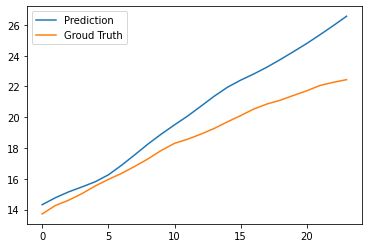

(11, 4)
MAPE: 0.22640137374401093
Test loss: 287.088134765625


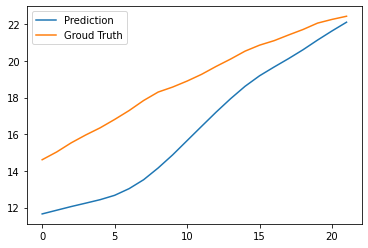

(11, 6)
MAPE: 0.1975097954273224
Test loss: 289.4386291503906


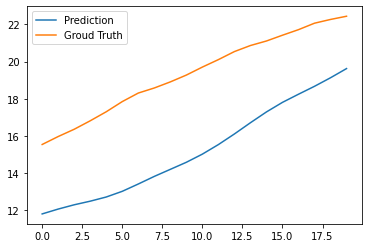

(11, 8)
MAPE: 0.23232519626617432
Test loss: 285.74725341796875


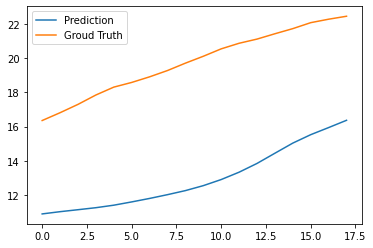

(13, 2)
MAPE: 0.15166692435741425
Test loss: 80.8739242553711


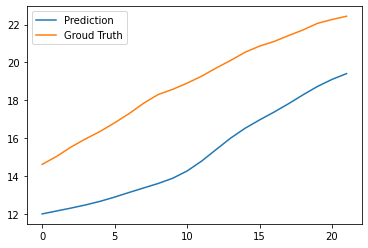

(13, 4)
MAPE: 0.10283128172159195
Test loss: 88.40961456298828


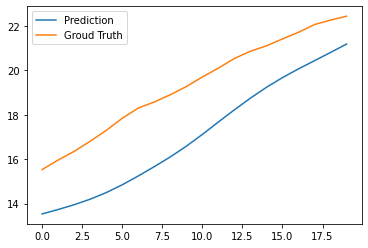

(13, 6)
MAPE: 0.13088983297348022
Test loss: 99.0496826171875


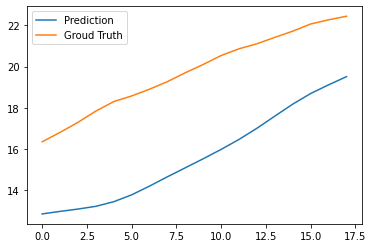

(13, 8)
MAPE: 0.15570630133152008
Test loss: 117.53817749023438


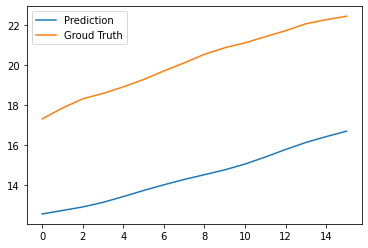

(15, 2)
MAPE: 0.10708121210336685
Test loss: 49.274749755859375


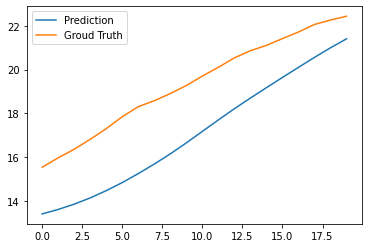

(15, 4)
MAPE: 0.1233554556965828
Test loss: 57.292606353759766


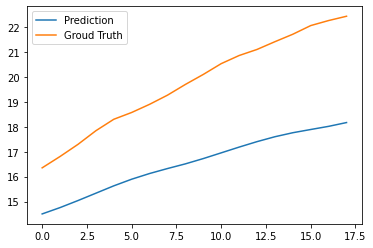

(15, 6)
MAPE: 0.1620243489742279
Test loss: 61.1269416809082


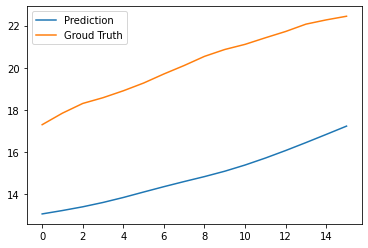

(15, 8)
MAPE: 0.13923586905002594
Test loss: 64.7735595703125


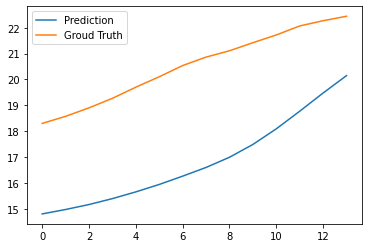

(17, 2)
MAPE: 0.12158705294132233
Test loss: 54.34967041015625


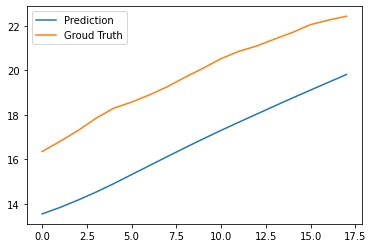

(17, 4)
MAPE: 0.13511240482330322
Test loss: 45.24610137939453


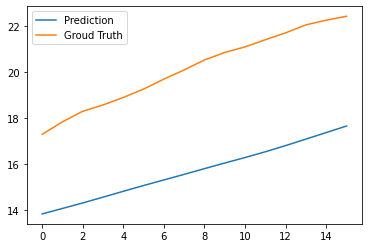

(17, 6)
MAPE: 0.14053773880004883
Test loss: 61.427303314208984


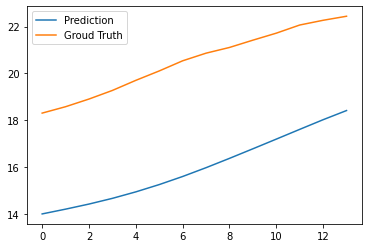

(17, 8)
MAPE: 0.17111317813396454
Test loss: 51.12504577636719


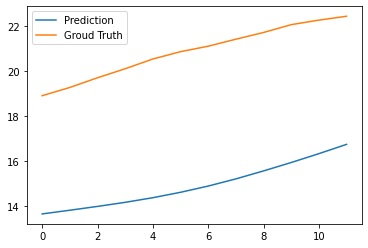

(19, 2)
MAPE: 0.14825403690338135
Test loss: 49.17313766479492


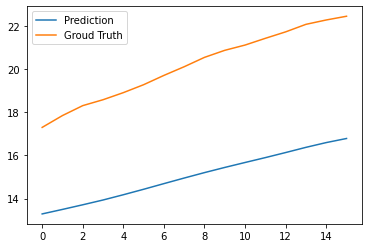

(19, 4)
MAPE: 0.148356094956398
Test loss: 57.784523010253906


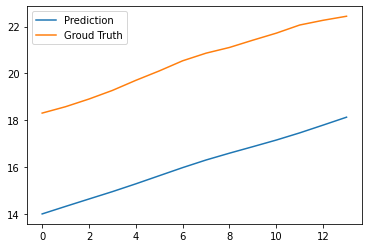

(19, 6)
MAPE: 0.19350674748420715
Test loss: 87.50697326660156


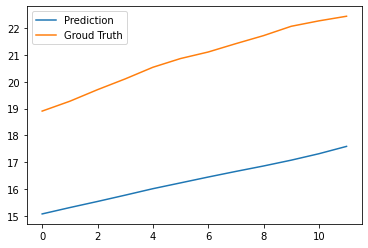

(19, 8)
MAPE: 0.16654926538467407
Test loss: 51.65901565551758


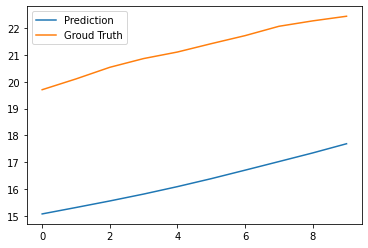

(21, 2)
MAPE: 0.14893852174282074
Test loss: 54.067413330078125


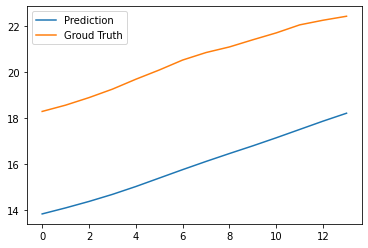

(21, 4)
MAPE: 0.13958965241909027
Test loss: 53.92005157470703


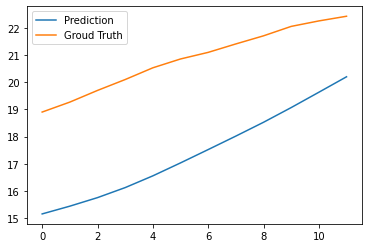

(21, 6)
MAPE: 0.16201621294021606
Test loss: 47.9012451171875


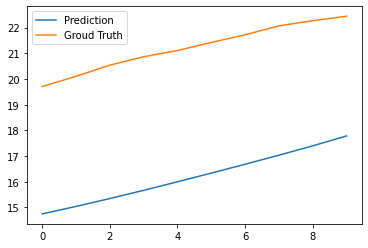

(21, 8)
MAPE: 0.18849362432956696
Test loss: 61.64661407470703


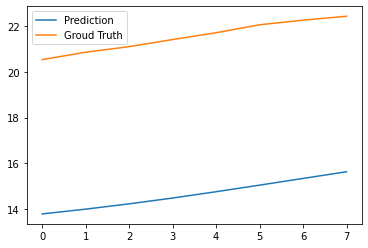

(23, 2)
MAPE: 0.1574988216161728
Test loss: 50.041072845458984


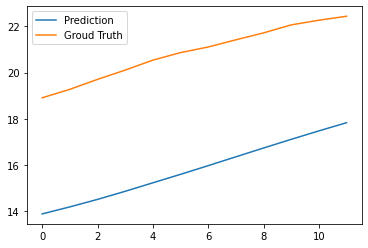

(23, 4)
MAPE: 0.1633007973432541
Test loss: 56.509037017822266


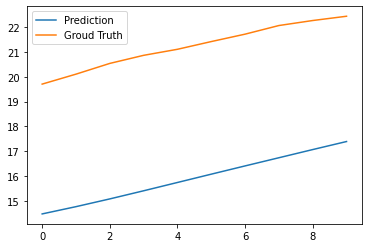

(23, 6)
MAPE: 0.13259638845920563
Test loss: 52.18830871582031


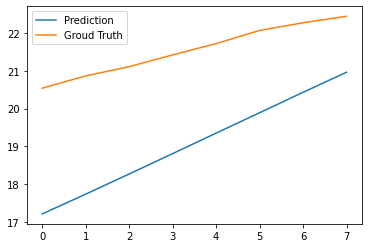

(23, 8)
MAPE: 0.1685713678598404
Test loss: 47.095428466796875


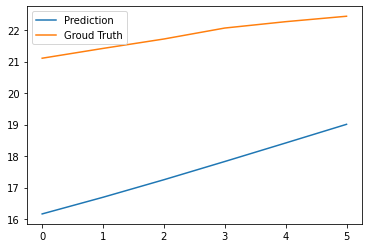

In [13]:
'''save the mape value with corresponding key(num_timesteps_input, num_timesteps_output)'''
MAPE_list = {}
for num_timesteps_input in range(11,25,2):
    for num_timesteps_output in range(2,10,2):
        print((num_timesteps_input, num_timesteps_output))
        MAPE_list[(num_timesteps_input, num_timesteps_output)] = training(num_timesteps_input, num_timesteps_output, A, X, epochs = 51)

In [14]:
MAPE_list

{(11, 2): 0.19611701,
 (11, 4): 0.22640137,
 (11, 6): 0.1975098,
 (11, 8): 0.2323252,
 (13, 2): 0.15166692,
 (13, 4): 0.10283128,
 (13, 6): 0.13088983,
 (13, 8): 0.1557063,
 (15, 2): 0.10708121,
 (15, 4): 0.123355456,
 (15, 6): 0.16202435,
 (15, 8): 0.13923587,
 (17, 2): 0.12158705,
 (17, 4): 0.1351124,
 (17, 6): 0.14053774,
 (17, 8): 0.17111318,
 (19, 2): 0.14825404,
 (19, 4): 0.1483561,
 (19, 6): 0.19350675,
 (19, 8): 0.16654927,
 (21, 2): 0.14893852,
 (21, 4): 0.13958965,
 (21, 6): 0.16201621,
 (21, 8): 0.18849362,
 (23, 2): 0.15749882,
 (23, 4): 0.1633008,
 (23, 6): 0.13259639,
 (23, 8): 0.16857137}

In [15]:
np.save('loss',np.array(list(MAPE_list.values())))

In [22]:
list(MAPE_list.keys()),list(MAPE_list.values())

([(11, 2),
  (11, 4),
  (11, 6),
  (11, 8),
  (13, 2),
  (13, 4),
  (13, 6),
  (13, 8),
  (15, 2),
  (15, 4),
  (15, 6),
  (15, 8),
  (17, 2),
  (17, 4),
  (17, 6),
  (17, 8),
  (19, 2),
  (19, 4),
  (19, 6),
  (19, 8),
  (21, 2),
  (21, 4),
  (21, 6),
  (21, 8),
  (23, 2),
  (23, 4),
  (23, 6),
  (23, 8)],
 [0.19611701,
  0.22640137,
  0.1975098,
  0.2323252,
  0.15166692,
  0.10283128,
  0.13088983,
  0.1557063,
  0.10708121,
  0.123355456,
  0.16202435,
  0.13923587,
  0.12158705,
  0.1351124,
  0.14053774,
  0.17111318,
  0.14825404,
  0.1483561,
  0.19350675,
  0.16654927,
  0.14893852,
  0.13958965,
  0.16201621,
  0.18849362,
  0.15749882,
  0.1633008,
  0.13259639,
  0.16857137])

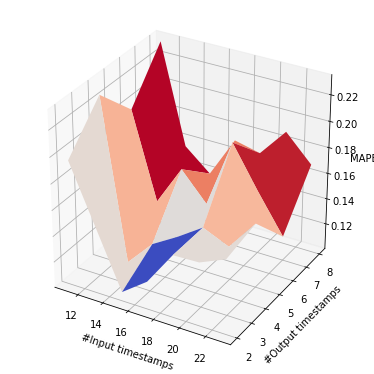

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)
#In_time = [11,13,15,17,19,21,23,25]
#Out_time = [2,4,6,8,10]
In_time = list(range(11,25,2))
Out_time = list(range(2,10,2))
In_time,Out_time = np.meshgrid(In_time,Out_time)

loss_plot = np.zeros(In_time.shape)
for aa in range(In_time.shape[0]):
    for bb in range(In_time.shape[1]):
        loss_plot[aa,bb] = MAPE_list[(In_time[aa,bb],Out_time[aa,bb])]

        
ax.set_xlabel("#Input timestamps")
ax.set_ylabel("#Output timestamps")
ax.set_zlabel("MAPE")

ax.plot_surface(In_time,Out_time,loss_plot,rstride=1,cstride=2,cmap=cm.coolwarm)

fig.savefig("lossmap.png")